# Zerobase EDA 과제2

## 주유소 데이터 분석

### 한글 깨짐 방지

Text(0.5, 1.0, '데이터 사이언스')

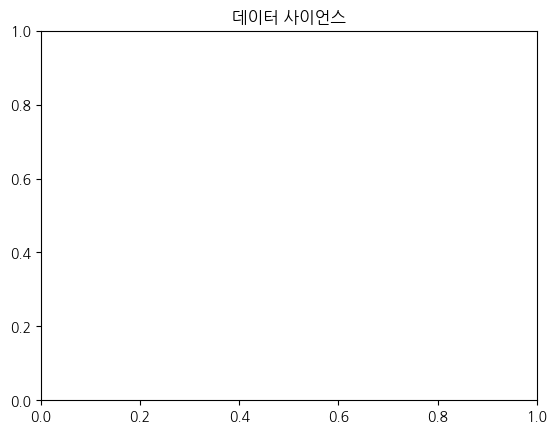

In [1]:
import koreanize_matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.title('데이터 사이언스')

## [문제 1] 서울시의 주유소 데이터를 엑셀 파일이 아닌 크롤링 코드로 수집해서 pandas data frame으로 정리해 두세요.(데이터 프레임에 들어가야할 컬럼: 주유소명, 주소, 브랜드, 휘발유 가격, 경유 가격, 셀프 여부, 세차장 여부, 충전소 여부, 경정비 여부, 편의점 여부, 24시간 운영 여부, 구, 위도, 경도)

주유소 지도 홈페이지 - https://www.opinet.co.kr/searRgSelect.do

In [116]:
# 주유소 홈페이지 접속
from selenium import webdriver

driver = webdriver.Chrome()
driver.get('https://www.opinet.co.kr/searRgSelect.do')

In [117]:
from selenium.webdriver.common.by import By

# 우리의 관심 지역은 서울이니 selectbox에서 option값을 서울로 고정시키는 과정
sido_list = driver.find_element(By.ID, 'SIDO_NM0')
sido = sido_list.find_elements(By.TAG_NAME, 'option')
sido_names = [option.get_attribute('value') for option in sido]
sido_names = sido_names[1:]
sido_list.send_keys(sido_names[0])

In [118]:
# 위와 마찬가지의 방법으로 구 이름을 리스트에 담기
gu_list = driver.find_element(By.ID, 'SIGUNGU_NM0')
gu = gu_list.find_elements(By.TAG_NAME, 'option') 
gu_names = [option.get_attribute("value") for option in gu]
gu_names = gu_names[1:]
gu_names

['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

In [119]:
from tqdm import tqdm_notebook
from bs4 import BeautifulSoup
import time
import pandas as pd

datas = []

for g in tqdm_notebook(gu_names):
    # 구 바꿔주기
    gu_change = driver.find_element(By.ID, 'SIGUNGU_NM0')
    gu_change.send_keys(g)

    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 검색 결과 개수 저장
    result_cnt = int(soup.find(id='totCnt').text)

    # 검색 결과 개수동안 반복
    for i in range(1, result_cnt+1):
        driver.find_element(By.CSS_SELECTOR, f'#body1 > tr:nth-child({i}) > td.rlist > a').click()

        html2 = driver.page_source
        soup2 = BeautifulSoup(html2, 'html.parser')

        # 주유소 이름
        name = soup2.find(id='os_nm').text
        # 주소
        address = soup2.find(id='rd_addr').text
        # 구
        gu_name = address.split()[1]
        # 브랜드
        brand = soup2.find(id='poll_div_nm').text
        # 휘발유 가격
        gasoline = int(''.join(soup2.find(id='b027_p').text.split(',')))
        # 경유 가격
        oil = int(''.join(soup2.find(id='d047_p').text.split(',')))
        # 셀프 여부
        if soup2.find(class_='header').find(id='SPAN_SELF_VLT_YN_ID').find(id='self_icon'):
            self = 'Y'
        else:
            self = 'N'
        # 세차장 여부
        if soup2.find(class_='service').find(id='cwsh_yn')['src'] == '/images/user/gis/oil_station_service1_01.gif':
            wash = 'Y'
        else:
            wash = 'N'
        # 충전소 여부
        if soup2.find(class_='service').find(id='lpg_yn')['src'] == '/images/user/gis/oil_station_service1_02_01.gif':
            lpg = 'Y'
        else:
            lpg = 'N'
        # 경정비 여부
        if soup2.find(class_='service').find(id='maint_yn')['src'] == '/images/user/gis/oil_station_service1_03.gif':
            main = 'Y'
        else:
            main = 'N'
        # 편의점 여부
        if soup2.find(class_='service').find(id='cvs_yn')['src'] == '/images/user/gis/oil_station_service1_04.gif':
            store = 'Y'
        else:
            store = 'N'
        # 24시간 운영 여부
        if soup2.find(class_='service').find(id='sel24_yn')['src'] == '/images/user/gis/oil_station_service1_05.gif':
            hour = 'Y'
        else:
            hour = 'N'
        
        datas.append({'이름': name, 
                      '주소': address,
                      '브랜드': brand,
                      '휘발유 가격': gasoline,
                      '경유 가격': oil,
                      '셀프': self,
                      '세차장': wash,
                      '충전소': lpg,
                      '경정비': main,
                      '편의점': store,
                      '24시간 운영': hour,
                      '구': gu_name})
        time.sleep(0.5)

C:\Users\emddj\AppData\Local\Temp\ipykernel_13928\2763634591.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for g in tqdm_notebook(gu_names):


  0%|          | 0/25 [00:00<?, ?it/s]

In [122]:
# 데이터 프레임으로 변환
oil_df = pd.DataFrame(datas)
oil_df

,이름,주소,브랜드,휘발유 가격,경유 가격,셀프,세차장,충전소,경정비,편의점,24시간 운영,구
0,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,1629,1539,Y,Y,N,N,N,N,강남구
1,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,1655,1565,Y,Y,N,N,N,N,강남구
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,1687,1589,Y,Y,N,N,N,N,강남구
3,오일프러스 셀프,서울 강남구 남부순환로 2651 (도곡동),SK에너지,1688,1595,Y,Y,N,Y,N,Y,강남구
4,(주)중앙에너비스 수서지점,서울 강남구 광평로 202 (수서동),SK에너지,1697,1597,Y,Y,N,N,N,N,강남구
...,...,...,...,...,...,...,...,...,...,...,...,...
431,(주)기지에너지,서울 중랑구 용마산로 716 (신내동),S-OIL,1639,1539,N,N,N,N,N,N,중랑구
432,신내주유소,서울 중랑구 용마산로 705 (신내동),SK에너지,1652,1553,Y,Y,N,N,N,N,중랑구
433,신일셀프주유소,서울 중랑구 상봉로 58 (망우동),SK에너지,1659,1568,Y,Y,N,Y,N,Y,중랑구
434,용마로주유소,서울 중랑구 용마산로 309 (면목동),SK에너지,1678,1558,Y,Y,N,N,N,N,중랑구


In [127]:
# 위도, 경도 저장하기
import googlemaps
import numpy as np

# API 가져오기
gmaps_key = ""
gmaps = googlemaps.Client(key=gmaps_key)

lat = []
lng = []

for idx, rows in tqdm_notebook(oil_df.iterrows()):
    addr_detail = gmaps.geocode(rows["주소"], language="ko")
    if addr_detail:
        location_ouput = addr_detail[0].get("geometry")
        lat.append(location_ouput["location"]["lat"])
        lng.append(location_ouput["location"]["lng"])
    else:
        lat.append(np.nan)
        lng.append(np.nan)

C:\Users\emddj\AppData\Local\Temp\ipykernel_13928\554031097.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, rows in tqdm_notebook(oil_df.iterrows()):


0it [00:00, ?it/s]

In [128]:
oil_df['위도'] = lat
oil_df['경도'] = lng

In [129]:
oil_df

,이름,주소,브랜드,휘발유 가격,경유 가격,셀프,세차장,충전소,경정비,편의점,24시간 운영,구,위도,경도
0,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,1629,1539,Y,Y,N,N,N,N,강남구,37.467157,127.118708
1,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,1655,1565,Y,Y,N,N,N,N,강남구,37.466567,127.119080
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,1687,1589,Y,Y,N,N,N,N,강남구,37.474993,127.106887
3,오일프러스 셀프,서울 강남구 남부순환로 2651 (도곡동),SK에너지,1688,1595,Y,Y,N,Y,N,Y,강남구,37.485839,127.039672
4,(주)중앙에너비스 수서지점,서울 강남구 광평로 202 (수서동),SK에너지,1697,1597,Y,Y,N,N,N,N,강남구,37.484105,127.095040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,(주)기지에너지,서울 중랑구 용마산로 716 (신내동),S-OIL,1639,1539,N,N,N,N,N,N,중랑구,37.617628,127.094381
432,신내주유소,서울 중랑구 용마산로 705 (신내동),SK에너지,1652,1553,Y,Y,N,N,N,N,중랑구,37.617125,127.095896
433,신일셀프주유소,서울 중랑구 상봉로 58 (망우동),SK에너지,1659,1568,Y,Y,N,Y,N,Y,중랑구,37.590942,127.093807
434,용마로주유소,서울 중랑구 용마산로 309 (면목동),SK에너지,1678,1558,Y,Y,N,N,N,N,중랑구,37.579878,127.092182


In [130]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   이름       436 non-null    object 
 1   주소       436 non-null    object 
 2   브랜드      436 non-null    object 
 3   휘발유 가격   436 non-null    int64  
 4   경유 가격    436 non-null    int64  
 5   셀프       436 non-null    object 
 6   세차장      436 non-null    object 
 7   충전소      436 non-null    object 
 8   경정비      436 non-null    object 
 9   편의점      436 non-null    object 
 10  24시간 운영  436 non-null    object 
 11  구        436 non-null    object 
 12  위도       436 non-null    float64
 13  경도       436 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 47.8+ KB


In [131]:
# 데이터 저장
oil_df.to_csv('seoul_oil.csv')

In [125]:
driver.close()

## [문제 2] 데이터 분석 - 휘발유와 경유 가격이 셀프 주유소에서 정말 저렴한가?

### 먼저 휘발유 값에 따라 비교해보자

In [134]:
# 휘발유 값이 가장 비싼 주유소 5개 
oil_df.sort_values(by="휘발유 가격", ascending=False).head(5)

,이름,주소,브랜드,휘발유 가격,경유 가격,셀프,세차장,충전소,경정비,편의점,24시간 운영,구,위도,경도
422,서남주유소,서울 중구 통일로 30,SK에너지,2697,2563,N,Y,N,N,N,Y,중구,37.558375,126.972094
389,서계주유소,서울 용산구 청파로 367 (청파동),GS칼텍스,2693,2729,N,Y,N,N,N,N,용산구,37.552329,126.968946
31,(주)만정에너지 삼보주유소,서울 강남구 봉은사로 433 (삼성동),GS칼텍스,2598,2560,N,Y,N,N,N,N,강남구,37.511521,127.047172
30,(주)제이제이네트웍스 제이제이주유소,서울 강남구 언주로 716,HD현대오일뱅크,2490,2380,N,Y,N,N,N,Y,강남구,37.517647,127.035735
421,필동주유소,서울 중구 퇴계로 196 (필동2가),GS칼텍스,2469,2329,N,N,N,N,N,Y,중구,37.558773,126.994721


- 휘발유 값이 가장 비싼 주유소는 중구의 서남주유소, 용산구의 서계주유소, 강남구의 (주)만정에너지 삼보주유소, 강남구의 (주)제이제이네트웍스 제이제이주유소, 중구의 필동주유소 순이다.
- 그런데, 신기한 것은 휘발유 값이 가장 비싼 주유소 5개를 추출해봤을 때 셀프 주유소가 아닌 것으로 확인이 된다.

In [135]:
# 휘발유 값이 가장 싼 주유소 5개 
oil_df.sort_values(by="휘발유 가격", ascending=True).head(5)

,이름,주소,브랜드,휘발유 가격,경유 가격,셀프,세차장,충전소,경정비,편의점,24시간 운영,구,위도,경도
229,만남의광장주유소,서울 서초구 양재대로12길 73-71,알뜰(ex),1567,1470,Y,N,Y,N,Y,Y,서초구,37.460084,127.042169
328,플라트(주)서호주유소,서울 양천구 남부순환로 317,GS칼텍스,1573,1473,Y,Y,N,Y,N,N,양천구,37.538661,126.826837
260,(주)서울에너지 직영,서울 성동구 천호대로 324 (용답동),S-OIL,1573,1473,Y,Y,N,N,N,Y,성동구,37.564261,127.055685
58,화곡역주유소,서울 강서구 강서로 154 (화곡동),알뜰주유소,1573,1473,Y,N,N,N,N,Y,강서구,37.540719,126.841530
57,이케이에너지(주) 강서주유소,서울 강서구 화곡로 273 (화곡동),HD현대오일뱅크,1573,1473,Y,Y,N,Y,N,N,강서구,37.549163,126.846996


- 휘발유 값이 가장 싼 주유소는 서초구의 만남의광장주유소, 양천구의 플라트(주)서호주유소, 성동구의 (주)서울에너지 직영, 강서구의 화곡역주유소, 강서구의 이케이에너지(주) 강서주유소 순이다.
- 그런데, 또 신기한 것은 휘발유 값이 가장 싼 주유소 5개를 추출해봤을 때 셀프 주유소인 것으로 확인이 된다.

### 그럼 경유 값도 비교해보자

In [136]:
# 경유 값이 가장 비싼 주유소 5개 
oil_df.sort_values(by="경유 가격", ascending=False).head(5)

,이름,주소,브랜드,휘발유 가격,경유 가격,셀프,세차장,충전소,경정비,편의점,24시간 운영,구,위도,경도
389,서계주유소,서울 용산구 청파로 367 (청파동),GS칼텍스,2693,2729,N,Y,N,N,N,N,용산구,37.552329,126.968946
422,서남주유소,서울 중구 통일로 30,SK에너지,2697,2563,N,Y,N,N,N,Y,중구,37.558375,126.972094
31,(주)만정에너지 삼보주유소,서울 강남구 봉은사로 433 (삼성동),GS칼텍스,2598,2560,N,Y,N,N,N,N,강남구,37.511521,127.047172
377,SJ오일(주) 여의도주유소,서울 영등포구 은행로 64,GS칼텍스,2295,2395,N,Y,Y,N,Y,Y,영등포구,37.530380,126.925578
30,(주)제이제이네트웍스 제이제이주유소,서울 강남구 언주로 716,HD현대오일뱅크,2490,2380,N,Y,N,N,N,Y,강남구,37.517647,127.035735


- 경유 값이 가장 비싼 주유소는 용산구의 서계주유소, 중구의 서남주유소, 강남구의 (주)만정에너지 삼보주유소, 영등포구의 SJ오일(주) 여의도주유소, 강남구의 (주)제이제이네트웍스 제이제이주유소 순이다.
- 휘발유와 마찬가지로 경유도 역시 가장 비싼 주유소 5개 모두 셀프 주유소가 아니다.

In [137]:
# 경유 값이 가장 싼 주유소 5개 
oil_df.sort_values(by="경유 가격", ascending=True).head(5)

,이름,주소,브랜드,휘발유 가격,경유 가격,셀프,세차장,충전소,경정비,편의점,24시간 운영,구,위도,경도
229,만남의광장주유소,서울 서초구 양재대로12길 73-71,알뜰(ex),1567,1470,Y,N,Y,N,Y,Y,서초구,37.460084,127.042169
327,현대주유소,서울 양천구 남부순환로 372 (신월동),S-OIL,1573,1473,Y,Y,N,N,N,N,양천구,37.533873,126.829262
260,(주)서울에너지 직영,서울 성동구 천호대로 324 (용답동),S-OIL,1573,1473,Y,Y,N,N,N,Y,성동구,37.564261,127.055685
328,플라트(주)서호주유소,서울 양천구 남부순환로 317,GS칼텍스,1573,1473,Y,Y,N,Y,N,N,양천구,37.538661,126.826837
58,화곡역주유소,서울 강서구 강서로 154 (화곡동),알뜰주유소,1573,1473,Y,N,N,N,N,Y,강서구,37.540719,126.841530


- 경유 값이 가장 싼 주유소는 서초구의 만남의광장주유소, 양천구의 현대주유소, 성동구의 (주)서울에너지 직영, 양천구의 플라트(주)서호주유소, 강서구의 화곡역주유소 순이다.
- 휘발유와 마찬가지로 경유도 역시 가장 싼 주유소 5개 모두 셀프 주유소이다.

그럼 정말 셀프 주유소가 휘발유와 경유 값이 더 저렴한 걸까?

### 이번엔 시각화로 비교해보자

C:\Users\emddj\AppData\Local\Temp\ipykernel_13928\839988585.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="셀프", y="휘발유 가격", data=oil_df, palette="Set1")


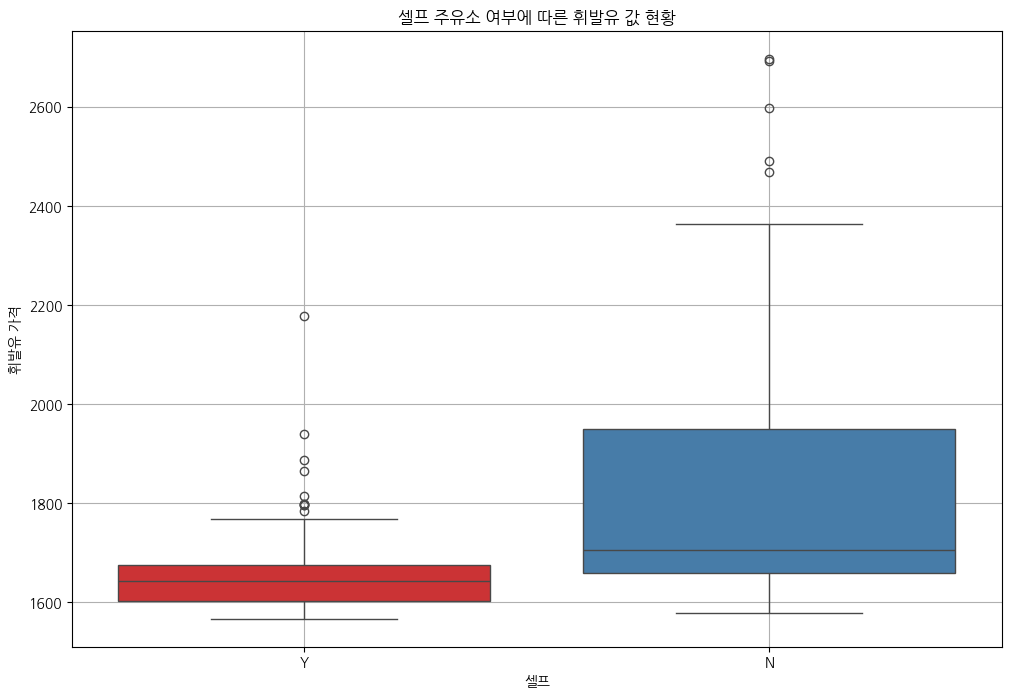

In [138]:
# 셀프 주유소 여부에 따른 휘발유 값 비교
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x="셀프", y="휘발유 가격", data=oil_df, palette="Set1")
plt.title('셀프 주유소 여부에 따른 휘발유 값 현황')
plt.grid(True)
plt.show()

C:\Users\emddj\AppData\Local\Temp\ipykernel_13928\900254262.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="셀프", y="경유 가격", data=oil_df, palette="Set1")


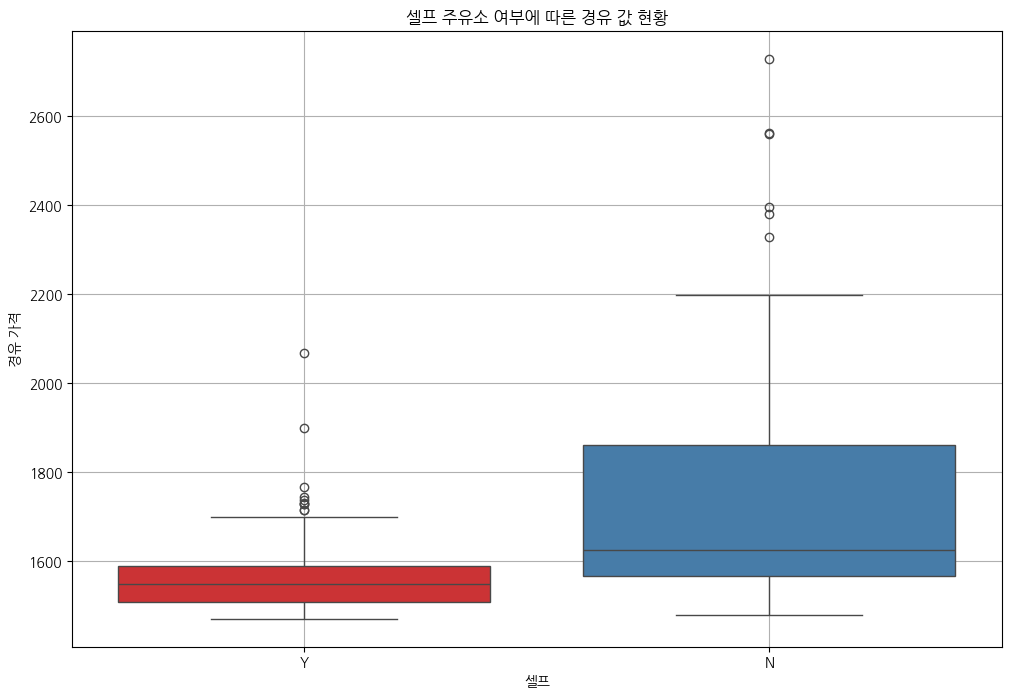

In [139]:
# 셀프 주유소 여부에 따른 경유 값 비교
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x="셀프", y="경유 가격", data=oil_df, palette="Set1")
plt.title('셀프 주유소 여부에 따른 경유 값 현황')
plt.grid(True)
plt.show()

전체적인 데이터로 확인했을 때에도 휘발유, 경유 모두 셀프 주유소인 곳에서 가격이 더 저렴한 것을 확인할 수 있다.

### 그럼 이번에는 브랜드 별로도 비교해보자

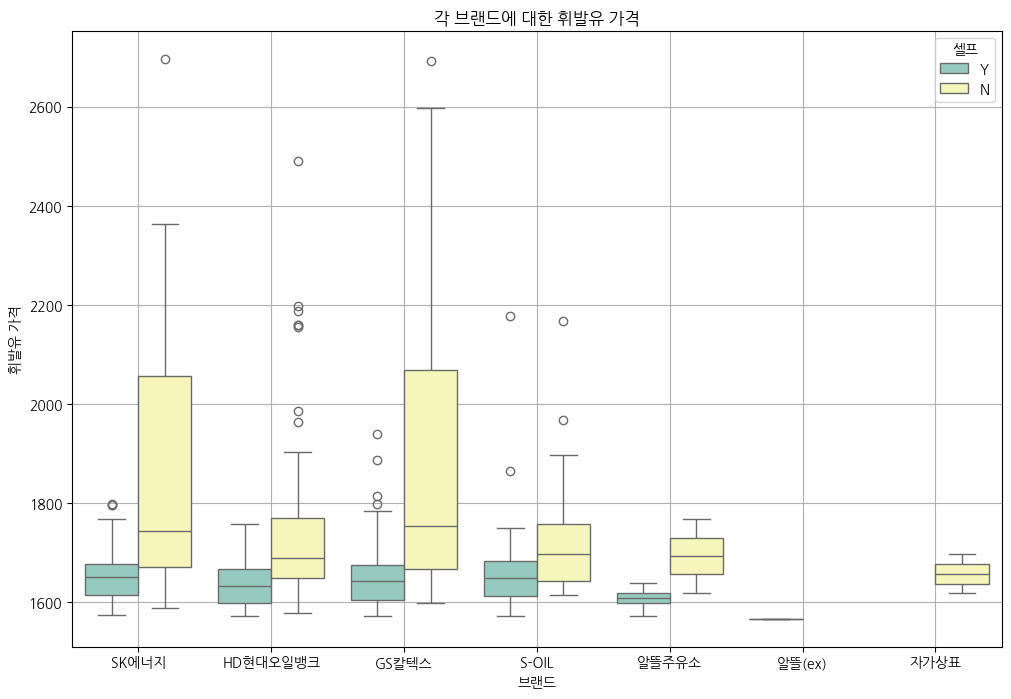

In [140]:
# 브랜드마다의 휘발유 가격과 셀프 주유소인지 아닌지 구분도 지정해서 시각화
plt.figure(figsize=(12, 8))
sns.boxplot(x="브랜드", y="휘발유 가격", hue="셀프", data=oil_df, palette="Set3")
plt.grid(True)
plt.title('각 브랜드에 대한 휘발유 가격')
plt.show()

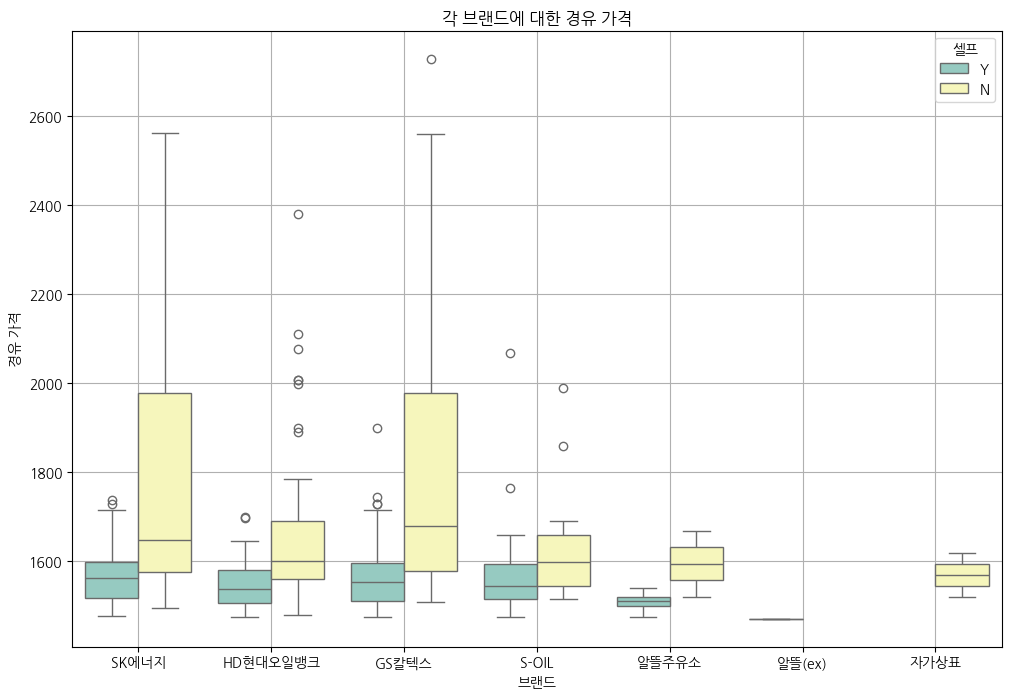

In [141]:
# 브랜드마다의 경유 가격과 셀프 주유소인지 아닌지 구분도 지정해서 시각화
plt.figure(figsize=(12, 8))
sns.boxplot(x="브랜드", y="경유 가격", hue="셀프", data=oil_df, palette="Set3")
plt.grid(True)
plt.title('각 브랜드에 대한 경유 가격')
plt.show()

- 모든 브랜드가 셀프 주유소인 곳의 휘발유, 경유 가격이 모두 저렴한 것을 알 수 있다.

## 결론
- 휘발유, 경유 값이 가장 비싼 주유소 5곳은 모두 셀프 주유소가 아니다.
- 휘발유, 경유 값이 가장 싼 주유소 5곳은 모두 셀프 주유소이다.
- 전체적인 데이터로 보았을 때에도 셀프 주유소인 곳이 휘발유, 경우 값이 모두 저렴했다.
- 브랜드별로 보았을 때에도 셀프 주유소인 곳이 휘발유, 경유 값이 모두 저렴했다. <br>
### 셀프 주유소의 유무에 따라 휘발유, 경유 값이 영향이 있다. 그 중에서도 셀프 주유소인 곳은 휘발유, 경유 값 모두 저렴하다고 볼 수 있다.